# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, <b>TreasureMaze.py</b>, represents the environment, which includes a maze object defined as a matrix. The second class, <b>GameExperience.py</b>, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation in the qtrain() function for which a skeleton implementation has been provided. 

The code block you will need to complete has <b>#TODO</b> as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

<div class="alert alert-block alert-warning" style="color: #333333;">
<b>Installations</b> The following command will install the necessary Python libraries to necessary to run this application. If you see a "[notice] A new release of pip is available: 23.1.2 -> 25.2" at the end of the installation, you may disregard that statement. 
</div>

In [1]:
!pip install -r requirements.txt

<h2>Tensorflow CPU Acceleration Warning</h2>
<div class="alert alert-block alert-danger" style="color: #333333;">
    You will see a <b>warning in red</b> "oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders". This is simply coming from <b>Tensorflow to accelerate computations on CPU.</b>  
</div>

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import clone_model
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

<h2> Maze Object Generation</h2>

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

<h2>Helper Functions and Global Variables</h2>

This <b>show()</b> helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The <b>pirate agent</b> can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is the EXPLORATION values from the Cartpole assignment. The hyperparameters are provided here and used in the qtrain() method. 
You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
patience = 10

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


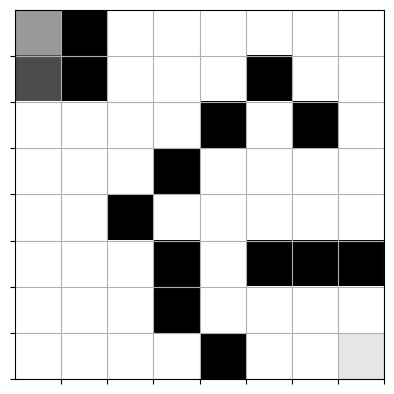

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This <b>play_game()</b> function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object, the starting position of the pirate and max amount of steps to make sure the code does not get stuck in a loop.

In [7]:
def play_game(model, qmaze, pirate_cell, max_steps=None):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    steps = 0
    if max_steps is None:
        max_steps = qmaze.maze.size * 4  # safety cutoff

    while steps < max_steps:
        state = np.asarray(envstate, dtype=np.float32)
        if state.ndim == 1:
            state = np.expand_dims(state, axis=0)

        q_values = model(state, training=False).numpy()
        action = np.argmax(q_values[0])

        envstate, reward, game_status = qmaze.act(action)
        steps += 1

        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

    return False  # timed out with no result

This <b>completion_check()</b> function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, maze_or_qmaze, max_steps=None):
    # Accept either raw numpy maze or TreasureMaze instance
    if isinstance(maze_or_qmaze, TreasureMaze):
        qmaze = maze_or_qmaze
    else:
        qmaze = TreasureMaze(maze_or_qmaze)

    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            continue
        if not play_game(model, qmaze, cell, max_steps=max_steps):
            return False
    return True

The <b>build_model()</b> function in the block below will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

This <b>train_step()</b> helper function in the block below is used to help predict Q-values (quality values) in the current modelto see how good each action is in a given state and improve the Q-network by reducing the gap between what is predicted and what should have been predicted. 

If you're interested in reading up on the <i>@tf.function</i>, which is a decorator for Tensorflow to run this code into a TensorFlow computation graph, please refer to this link: https://www.tensorflow.org/guide/intro_to_graphs



<h2>Tensorflow GPU Warning</h2>
<div class="alert alert-block alert-danger" style="color: #333333;">
    You will see a <b>warning in red</b> "INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.". This is simply coming from <b>Tensorflow skipping using GPU for this assignment.</b>  
 </div>

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        q_values = model(x, training=True)
        loss = loss_fn(y, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [11]:
# This is a small utility for printing readable time strings:
def format_time(seconds):
    # converts seconds into a easier to read string
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


def qtrain(model, maze, **opt):
    # exploration factor
    global epsilon 
    
    # Epsilon decay parameters
    epsilon_decay = opt.get('epsilon_decay', 0.995)  
    epsilon_min = opt.get('epsilon_min', 0.01)       
    
    # Number of epochs
    n_epoch = opt.get('n_epoch', 15000)
    
    # Maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)
    
    # Maximum data size for training
    data_size = opt.get('data_size', 50)
    
    # Frequency of target network updates
    target_update_freq = opt.get('target_update_freq', 50)
    
    # Start time
    start_time = datetime.datetime.now()
    
    # Construct environment/game from numpy array: maze
    qmaze = TreasureMaze(maze)
    
    # Target Network to better guide training
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())
    
    # Initialize experience replay object 
    experience = GameExperience(model, target_model, max_memory=max_memory)

    win_history = [] # list to track wins
    hsize = qmaze.maze.size // 2 # size of window for win rate
    win_rate = 0.0 # travk win rate
    
    # pseudocode:
    # For each epoch:
    for epoch in range(n_epoch): 
        # define and track loss and number of episodes
        loss = 0.0
        n_episodes = 0
        
        # Select a random starting position for the agent
        agent = random.choice(qmaze.free_cells)
        
        # Place the agent at the starting position
        qmaze.reset(agent)
        
        # Get the current state of the environment
        envstate = qmaze.observe()

        # Continue until the game is over (win or lose)
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate

            # Choose a random action
            if np.random.rand() < epsilon:
                action = random.choice(qmaze.valid_actions())
            else:
                # Choose the action with the highest Q-value
                action = int(np.argmax(experience.predict(previous_envstate)))

            # Perform the action and get the results
            envstate, reward, game_status = qmaze.act(action)

            # Package the experience into an episode
            episode = [previous_envstate, action, reward, envstate, game_status]

            # Store the episode in memory
            experience.remember(episode)

            # Count episode
            n_episodes += 1

            # Train neural network model on recent experience
            inputs, targets = experience.get_data()
            inputs, targets = inputs[-data_size:], targets[-data_size:]
            model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)

        # Once the game ends, get the final status
        game_status = qmaze.game_status()

        # Check if the game is over
        if game_status == 'win':
            win_history.append(1)
        else:
            win_history.append(0)



        # Calculate win rate
        if len(win_history) > 0:  # check / 0
            win_rate = sum(win_history[-hsize:]) / hsize
        else:
            win_rate = 0.0

        # Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        print("Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}".format(
            epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))

        # Adjust epsilon
        if win_rate > 0.9:
            epsilon = 0.05
        else:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
        # Check completion
        if win_rate >= 0.999 and completion_check(model, qmaze):
            print(f"Reached 100% win rate at epoch {epoch}")
            break

    # Determine the total time for training
    total_time = format_time((datetime.datetime.now() - start_time).total_seconds())
    print("Training complete in:", total_time)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an <b>instance</b> of TreasureMaze. This does not show your actual training done.

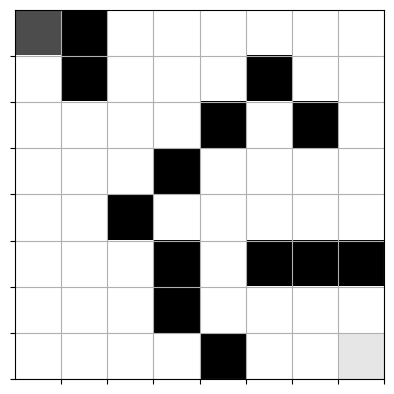

In [12]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model using the <b>build_model</b> function and train it using deep Q-learning. Note: This step takes several minutes to fully run.



<div class="alert alert-block alert-danger" style="color: #333333;">
    If you did not attempt the assignment, the code <b>will</b> error out at this section.
 </div>

In [13]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32, target_update_freq=50)

/usr/local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 000/999 | Loss: 0.0011 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 17.3 seconds
Epoch: 001/999 | Loss: 0.0004 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 36.5 seconds
Epoch: 002/999 | Loss: 0.0015 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 55.1 seconds
Epoch: 003/999 | Loss: 0.0012 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 73.3 seconds
Epoch: 004/999 | Loss: 0.0020 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 91.7 seconds
Epoch: 005/999 | Loss: 0.0008 | Episodes: 153 | Win count: 0 | Win rate: 0.000 | time: 112.0 seconds
Epoch: 006/999 | Loss: 0.0004 | Episodes: 157 | Win count: 0 | Win rate: 0.000 | time: 132.9 seconds
Epoch: 007/999 | Loss: 0.0017 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 152.1 seconds
Epoch: 008/999 | Loss: 0.0012 | Episodes: 147 | Win count: 1 | Win rate: 0.031 | time: 172.0 seconds
Epoch: 009/999 | Loss: 0.0017 | Episodes: 102 | Win count: 2 | Win rate: 0.062 | time: 185.5 sec

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

***Model passed check***


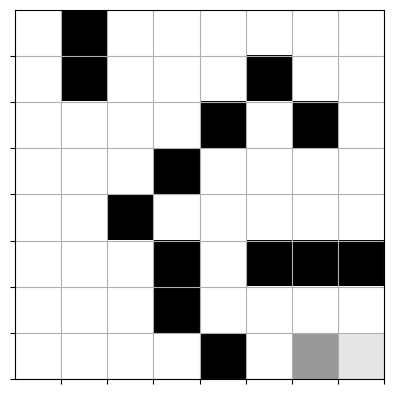

In [19]:
complete = completion_check(model, qmaze)
# check completion cehck is the pirate can win the game and returns true if it can and false if it can't
if complete:
    print("***Model passed check***") # completion check came back true
else:
    print("***Model failed check***") # completion check is false 
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run <b>play_game()</b>. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

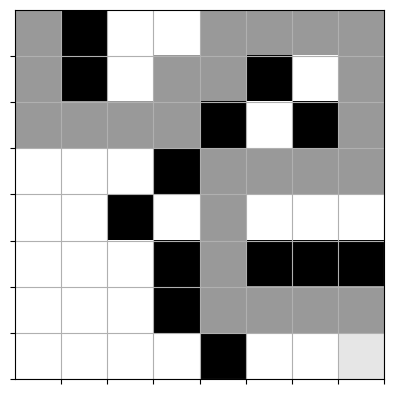

In [15]:
# after sucessfully training agent was able to reach the teasure starting from top left or 0,0 position
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

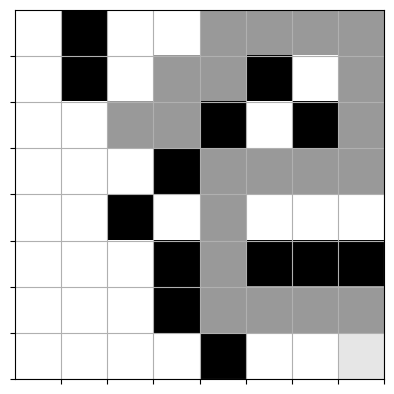

In [16]:
#test to ensure agent can reach treasure from a random position
pirate_start = random.choice(qmaze.free_cells)
play_game(model, qmaze, pirate_start)
show(qmaze)

# Analysis
- Early in training, the agent could not win any games; the first win occurred at epoch 8.
- Episode counts remained over 100 in early epochs, indicating early wins were likely due to luck rather than learned strategy.
- Episode counts began to decrease around epoch 128 and stayed in single or double digits, showing that the agent was learning efficiently.
- The agent achieved a 100% win rate at epoch 161 and was able to reach the treasure from every valid starting position by epoch 201.
- Completion check and additional play_game tests confirmed that the agent had learned optimal paths from all valid positions.
- The decreasing episode counts reflect the agent’s shift from random exploration to exploiting learned Q-values, resulting in more efficient paths.
- Training was completed in about 31 minutes, which is reasonable given the maze size.